In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import host, username, password
from pydataset import data
import os
from env import get_db_url
import acquire
import prepare
import scipy

In [2]:
#acquire data
df = acquire.get_titanic_data()

In [3]:
df

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,NaN,Southampton,1
887,887,1,1,female,19.0,0,0,30.0000,S,First,B,Southampton,1
888,888,0,3,female,NaN,1,2,23.4500,S,Third,NaN,Southampton,0
889,889,1,1,male,26.0,0,0,30.0000,C,First,C,Cherbourg,1


In [4]:

dummy1 = pd.get_dummies(df[['embark_town']],drop_first=True)
dummy2 = pd.get_dummies(df[['class']],drop_first=True)
df["is_female"] = (df.sex == "female")

In [5]:
df = pd.concat([df, dummy1, dummy2], axis=1)

In [6]:
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0,False,0,1,0,1
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0,True,0,0,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1,True,0,1,0,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0,True,0,1,0,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1,False,0,1,0,1


In [7]:
df = df.drop(columns=['passenger_id','age','sex', 'pclass','class', 'embarked','embark_town','deck','sibsp','parch'])

In [8]:
df.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third
0,0,7.2500,0,False,0,1,0,1
1,1,71.2833,0,True,0,0,0,0
2,1,7.9250,1,True,0,1,0,1
3,1,53.1000,0,True,0,1,0,0
4,0,8.0500,1,False,0,1,0,1


In [9]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 891 non-null    int64  
 1   fare                     891 non-null    float64
 2   alone                    891 non-null    int64  
 3   is_female                891 non-null    bool   
 4   embark_town_Queenstown   891 non-null    uint8  
 5   embark_town_Southampton  891 non-null    uint8  
 6   class_Second             891 non-null    uint8  
 7   class_Third              891 non-null    uint8  
dtypes: bool(1), float64(1), int64(2), uint8(4)
memory usage: 32.2 KB


In [10]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [11]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [12]:
#sanity check
train.shape, validate.shape, test.shape

((498, 8), (214, 8), (179, 8))

In [13]:
train['baseline_prediction'] = 0 #because I'm predicting more people did not survive
accuracy_score(train.survived, train.baseline_prediction)

0.6164658634538153

In [14]:

## make the model
model1 = DecisionTreeClassifier(splitter = 'best')

## fit the model
model1.fit(X_train, y_train)

print(f'training score: {model1.score(X_train, y_train):.2%}')
print(f'validate score: {model1.score(X_validate, y_validate):.2%}')

training score: 93.78%
validate score: 76.64%


In [15]:
train['model1'] = model1.predict(X_train)
train.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third,baseline_prediction,model1
583,0,40.1250,1,False,0,0,0,0,0,0
165,1,20.5250,0,False,0,1,0,1,0,0
50,0,39.6875,0,False,0,1,0,1,0,0
259,1,26.0000,0,True,0,1,1,0,0,1
306,1,110.8833,1,True,0,0,0,0,0,1


In [16]:
## use the model

y_pred = model1.predict(X_train)

In [17]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [18]:
#using model score
model1.score(X_validate,y_validate)

0.7663551401869159

In [19]:
confusion_matrix(y_train, y_pred)

array([[305,   2],
       [ 29, 162]])

In [20]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [21]:
#confusion matrix
pd.crosstab(y_train, y_pred)

col_0,0,1
survived,,
0,305,2
1,29,162


In [22]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       307
           1       0.99      0.85      0.91       191

    accuracy                           0.94       498
   macro avg       0.95      0.92      0.93       498
weighted avg       0.94      0.94      0.94       498



Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [23]:
tp = 162
tn = 305
fp = 29
fn = 2

In [24]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.9377510040160643
true positive rate is 0.3253012048192771
true negative rate is 0.6124497991967871
false positive rate is 0.05823293172690763
false negative rate is 0.004016064257028112
recall score is 0.8481675392670157
precision score is 0.9878048780487805
f1 score is 0.9126760563380283


Accuracy = 76.6% TP Rate = 61.2% FP = 5% TN = 32.5% FN = .4%

Run through steps 2-4 using a different max_depth value.

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

0.7616822429906542


[Text(167.4, 181.2, 'X[2] <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]'),
 Text(83.7, 108.72, 'X[0] <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]'),
 Text(41.85, 36.23999999999998, 'gini = 0.184\nsamples = 205\nvalue = [184, 21]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.43\nsamples = 118\nvalue = [81, 37]'),
 Text(251.10000000000002, 108.72, 'X[6] <= 0.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]'),
 Text(209.25, 36.23999999999998, 'gini = 0.081\nsamples = 94\nvalue = [4, 90]'),
 Text(292.95, 36.23999999999998, 'gini = 0.498\nsamples = 81\nvalue = [38, 43]')]

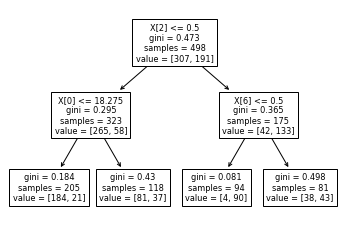

In [26]:
model2 = DecisionTreeClassifier(max_depth = 2)
model2.fit(X_train, y_train)
print(model2.score(X_validate,y_validate))
plot_tree(model2)

In [27]:
model2 = DecisionTreeClassifier(max_depth = 2)
model2.fit(X_train, y_train)

print(f'training score: {model2.score(X_train, y_train):.2%}')
print(f'validate score: {model2.score(X_validate, y_validate):.2%}')

training score: 79.92%
validate score: 76.17%


In [28]:
train['model2'] = model2.predict(X_train)
train.head()

,survived,fare,alone,is_female,embark_town_Queenstown,embark_town_Southampton,class_Second,class_Third,baseline_prediction,model1,model2
583,0,40.1250,1,False,0,0,0,0,0,0,0
165,1,20.5250,0,False,0,1,0,1,0,0,0
50,0,39.6875,0,False,0,1,0,1,0,0,0
259,1,26.0000,0,True,0,1,1,0,0,1,1
306,1,110.8833,1,True,0,0,0,0,0,1,1


In [29]:
y_pred = model2.predict(X_train)

In [30]:
pd.crosstab(y_train, y_pred)

col_0,0,1
survived,,
0,265,42
1,58,133


In [31]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [32]:
tp = 133
tn = 265
fp = 58
fn = 42

In [33]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.7991967871485943
true positive rate is 0.26706827309236947
true negative rate is 0.5321285140562249
false positive rate is 0.11646586345381527
false negative rate is 0.08433734939759036
recall score is 0.6963350785340314
precision score is 0.76
f1 score is 0.726775956284153


finish later Model2 with a higher max depth performed better than model1 for my in-data set. model2 also performs better on my out of sample data, it has a higher validate score at 76.9% while model1 has 76.6%.

In [34]:
## See initial notebook under classification project for running sequences for telco data

Continue working in your model file with titanic data to do the following:

Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [36]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [37]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [38]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [39]:
print(rf.feature_importances_)

[0.4722033  0.03597724 0.34596794 0.01424262 0.02909522 0.02125569
 0.081258  ]


In [40]:
y_pred = rf.predict(X_train)

In [41]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [42]:
y_pred_proba = rf.predict_proba(X_train)

In [43]:
y_pred_proba

array([[9.31307798e-01, 6.86922015e-02],
       [5.84150183e-01, 4.15849817e-01],
       [9.84845238e-01, 1.51547619e-02],
       [3.33333333e-03, 9.96666667e-01],
       [2.22222222e-03, 9.97777778e-01],
       [8.35555556e-01, 1.64444444e-01],
       [8.87466749e-01, 1.12533251e-01],
       [8.74638752e-01, 1.25361248e-01],
       [8.81590383e-01, 1.18409617e-01],
       [9.58333333e-01, 4.16666667e-02],
       [7.18681485e-01, 2.81318515e-01],
       [5.43546124e-01, 4.56453876e-01],
       [4.00000000e-02, 9.60000000e-01],
       [6.31883009e-01, 3.68116991e-01],
       [9.29522304e-01, 7.04776959e-02],
       [9.49246229e-01, 5.07537709e-02],
       [9.49246229e-01, 5.07537709e-02],
       [1.50483405e-02, 9.84951659e-01],
       [7.86961261e-01, 2.13038739e-01],
       [7.28823593e-01, 2.71176407e-01],
       [6.53712121e-02, 9.34628788e-01],
       [9.93326456e-01, 6.67354365e-03],
       [1.00000000e-02, 9.90000000e-01],
       [7.08333333e-02, 9.29166667e-01],
       [5.435461

In [44]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.94


In [45]:
print(confusion_matrix(y_train, y_pred))

[[301   6]
 [ 26 165]]


In [46]:
#using model score
rf.score(X_validate,y_validate)

0.7757009345794392

In [47]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       307
           1       0.96      0.86      0.91       191

    accuracy                           0.94       498
   macro avg       0.94      0.92      0.93       498
weighted avg       0.94      0.94      0.93       498



Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [48]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.9357429718875502
true positive rate is 0.26706827309236947
true negative rate is 0.5321285140562249
false positive rate is 0.11646586345381527
false negative rate is 0.08433734939759036
recall score is 0.8638743455497382
precision score is 0.9649122807017544
f1 score is 0.9116022099447514


Run through steps increasing your min_samples_leaf and decreasing your max_depth.



In [49]:
for i in range(2, 11):
    # Make the model
    tree = RandomForestClassifier(max_depth=i, min_samples_leaf = i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(f"min_samples_leaf {i-1}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
min_samples_leaf 1
                    0           1  accuracy   macro avg  weighted avg
precision    0.800000    0.797386  0.799197    0.798693      0.798997
recall       0.899023    0.638743  0.799197    0.768883      0.799197
f1-score     0.846626    0.709302  0.799197    0.777964      0.793958
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
min_samples_leaf 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.796196    0.892308  0.821285    0.844252      0.833058
recall       0.954397    0.607330  0.821285    0.780864      0.821285
f1-score     0.868148    0.722741  0.821285    0.795445      0.812380
support    307.000000  191.000000  0.821285  498.000000    498.000000

Tree with max depth of 4
min_samples_leaf 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.792453    0.897638  0.819277    0.845045      0.832795
recall       0.957655    0

Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, minmax_scale

In [51]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [52]:
y_pred = knn.predict(X_train)

In [53]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
y_pred_proba = knn.predict_proba(X_train)

In [55]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.84


Create a confusion matrix

In [56]:
print(confusion_matrix(y_train, y_pred))

[[291  16]
 [ 63 128]]


Create a classificaiton report

In [57]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       307
           1       0.89      0.67      0.76       191

    accuracy                           0.84       498
   macro avg       0.86      0.81      0.82       498
weighted avg       0.85      0.84      0.84       498



In [58]:
tp = 128
tn = 291
fp = 63
fn = 16

Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [59]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.8413654618473896
true positive rate is 0.2570281124497992
true negative rate is 0.5843373493975904
false positive rate is 0.12650602409638553
false negative rate is 0.0321285140562249
recall score is 0.6701570680628273
precision score is 0.8888888888888888
f1 score is 0.764179104477612


Run through steps 2-4 setting k to 10

In [60]:
knn10 = KNeighborsClassifier(n_neighbors = 10)
knn10.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [61]:
y_pred = knn10.predict(X_train)

In [62]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [63]:
y_pred_proba = knn10.predict_proba(X_train)

In [64]:
#model score
round(knn10.score(X_train,y_train),2)

0.79

In [65]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

[[273  34]
 [ 71 120]]


In [66]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       307
           1       0.78      0.63      0.70       191

    accuracy                           0.79       498
   macro avg       0.79      0.76      0.77       498
weighted avg       0.79      0.79      0.78       498



In [67]:
tp = 120
tn = 273
fp = 71
fn = 34

In [68]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.7891566265060241
true positive rate is 0.24096385542168675
true negative rate is 0.5481927710843374
false positive rate is 0.142570281124498
false negative rate is 0.06827309236947791
recall score is 0.6282722513089005
precision score is 0.7792207792207793
f1 score is 0.6956521739130436


5.) Run through setps 2-4 setting k to 20

In [69]:
knn20 = KNeighborsClassifier(n_neighbors = 20)
knn20.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [70]:
y_pred = knn20.predict(X_train)

In [71]:
y_pred_proba = knn20.predict_proba(X_train)

In [72]:
#model score
round(knn20.score(X_train,y_train),2)

0.74

In [73]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

[[265  42]
 [ 86 105]]


In [74]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.81       307
           1       0.71      0.55      0.62       191

    accuracy                           0.74       498
   macro avg       0.73      0.71      0.71       498
weighted avg       0.74      0.74      0.73       498



In [75]:
tp = 105
tn = 265
fp = 86
fn = 42

In [76]:
print(f'accuracy score is {accuracy_score(y_train, y_pred)}')
print(f'true positive rate is {tp / (tn + tp+fn+fp)}')
print(f'true negative rate is {tn / (tn + tp+fn+fp)}')
print(f'false positive rate is {fp / (tn + tp+fn+fp)}')
print(f'false negative rate is {fn / (tn + tp+fn+fp)}')
print(f'recall score is {metrics.recall_score(y_train, y_pred)}')
print(f'precision score is {metrics.precision_score(y_train, y_pred)}')
print(f'f1 score is {metrics.f1_score(y_train, y_pred)}')

accuracy score is 0.7429718875502008
true positive rate is 0.21084337349397592
true negative rate is 0.5321285140562249
false positive rate is 0.17269076305220885
false negative rate is 0.08433734939759036
recall score is 0.5497382198952879
precision score is 0.7142857142857143
f1 score is 0.621301775147929


In [77]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
tn, fp, fn, tp

(265, 42, 86, 105)

6.) What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [78]:
#My first model performed the best for in-sample data. The more you increased the k, the less accuracy, recall and precision it has.

7.) Which model performs best on our out-of-sample data from validate?

In [79]:
print('Accuracy of KNN classifier on training set n_neighbors set to 5: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set with n_neighbors set to 5: {:.2f}\n'
     .format(knn.score(X_validate, y_validate)))
print('Accuracy of KNN classifier on training set n_neighbors set to 10: {:.2f}'
     .format(knn10.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set with n_neighbors set to 10: {:.2f}\n'
     .format(knn10.score(X_validate, y_validate)))
print('Accuracy of KNN classifier on training set n_neighbors set to 20: {:.2f}'
     .format(knn20.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set with n_neighbors set to 20: {:.2f}'
     .format(knn20.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set n_neighbors set to 5: 0.84
Accuracy of KNN classifier on validate set with n_neighbors set to 5: 0.74

Accuracy of KNN classifier on training set n_neighbors set to 10: 0.79
Accuracy of KNN classifier on validate set with n_neighbors set to 10: 0.72

Accuracy of KNN classifier on training set n_neighbors set to 20: 0.74
Accuracy of KNN classifier on validate set with n_neighbors set to 20: 0.70


Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

Try out other combinations of features and models.

Use you best 3 models to predict and evaluate on your validate sample.

Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [80]:
#acquire data
df = acquire.get_titanic_data()

In [81]:
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [82]:
df.shape

(891, 13)

In [84]:
#split data
train, validate, test = prepare.prep_titanic_data(df, column = 'age', method = 'median', dummies = ['embarked', 'sex'])

In [85]:
train.head()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone,embarked_Q,embarked_S,sex_male
583,583,0,1,36.0,0,0,40.1250,1,0,0,1
165,165,1,3,9.0,0,2,20.5250,0,0,1,1
50,50,0,3,7.0,4,1,39.6875,0,0,1,1
259,259,1,2,50.0,0,1,26.0000,0,0,1,0
306,306,1,1,28.0,0,0,110.8833,1,0,0,0


In [86]:
train.shape

(498, 11)

In [87]:
#other way to do the split is decide wich columns we are going to use
X_cols = [ 'age','pclass', 'fare']
y_col = 'survived'

X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]

In [88]:
X_train.shape, X_validate.shape, X_test.shape

((498, 3), (214, 3), (179, 3))

In [89]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [90]:
#so the baselined is survived = 0
train['baseline'] = 0

In [91]:
print(f'The baseline accuracy for nonsurvival in all cases on the Titanic Dataset is {(train.baseline == train.survived).mean():.3}')

The baseline accuracy for nonsurvival in all cases on the Titanic Dataset is 0.616


In [94]:
from sklearn.linear_model import LogisticRegression
logit =LogisticRegression(C=1.0 , random_state=123)
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [95]:
# now use the model to make predictions
y_pred = logit.predict(X_train)

In [96]:
print('Accuracy: {:.2f}'.format(logit.score(X_train, y_train)))

Accuracy: 0.70


In [97]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       307
           1       0.67      0.43      0.53       191

    accuracy                           0.70       498
   macro avg       0.69      0.65      0.66       498
weighted avg       0.70      0.70      0.69       498



In [98]:
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

training score: 70.28%
validate score: 71.03%


In [99]:
X_cols = [ 'age','pclass', 'fare', 'sex_male']
y_col = 'survived'

X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]

In [100]:
logit2 =LogisticRegression(C=1.0 , random_state=123)
logit2.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [101]:
# now use the model to make predictions
y_pred = logit2.predict(X_train)

In [102]:
print(f'training score: {logit2.score(X_train, y_train):.2%}')
print(f'validate score: {logit2.score(X_validate, y_validate):.2%}')

training score: 80.72%
validate score: 78.04%


In [103]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       307
           1       0.76      0.73      0.74       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.79       498
weighted avg       0.81      0.81      0.81       498



In [104]:
logit3 =LogisticRegression(C=1 ,class_weight='balanced', random_state=123)
logit3.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [106]:
# now use the model to make predictions
y_pred = logit3.predict(X_train)

In [107]:
print(f'training score: {logit3.score(X_train, y_train):.2%}')
print(f'validate score: {logit3.score(X_validate, y_validate):.2%}')

training score: 80.12%
validate score: 75.70%


In [108]:
logit4 =LogisticRegression(penalty='l2',C=0.5, random_state=123, class_weight={0:61, 1:39})
logit4.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight={0: 61, 1: 39}, random_state=123)

In [109]:
print(f'training score: {logit4.score(X_train, y_train):.2%}')
print(f'validate score: {logit4.score(X_validate, y_validate):.2%}')

training score: 79.72%
validate score: 76.64%


In [110]:
logit2 =LogisticRegression(C=1.0 , random_state=123)
logit2.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [111]:
logit4 =LogisticRegression(penalty='l2',C=0.5, random_state=123, class_weight={0:61, 1:39})
logit4.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight={0: 61, 1: 39}, random_state=123)